# Using a linear regression predictive model to predict number of available bikes 

The model estimated is a linear model taking the form:

𝑡𝑎𝑟𝑔𝑒𝑡_𝑓𝑒𝑎𝑡𝑢𝑟𝑒=𝑤0+𝑤1∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒1+𝑤2∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒2+...+𝑤𝑛∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑛 

The target feature is availableBikes

### Reading Data

In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
# Allows plots to appear directly in the notebook.
%matplotlib inline
# filter warnings, we may want them but for now I removed them
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

In [2]:
# Read stations csv file stored after data prep into a dataframe.
df_availability_and_weather = pd.read_csv('stations_model_data.csv')
df_availability_and_weather.head()

,Unnamed: 0,stationId,totalStands,availableBikes,freeStands,lastUpdate,mainWeather,temperature,cloudiness,windSpeed,rain,snow,weekday,fullHour
0,0,2,20,10,10,2021-02-27 17:35:14,Clouds,9.34,75.0,2.57,0.0,0.0,Saturday,17
1,1,2,20,10,10,2021-02-27 17:45:23,Clouds,9.20,75.0,1.03,0.0,0.0,Saturday,17
2,2,2,20,10,10,2021-02-27 17:55:32,Clouds,9.48,75.0,1.03,0.0,0.0,Saturday,17
3,3,2,20,11,9,2021-02-27 18:00:42,Clouds,9.22,75.0,1.03,0.0,0.0,Saturday,18
4,4,2,20,11,9,2021-02-27 18:10:51,Clouds,8.85,75.0,0.51,0.0,0.0,Saturday,18


In [3]:
df_availability_and_weather.shape

(488580, 14)

In [4]:
df_availability_and_weather.dtypes

Unnamed: 0          int64
stationId           int64
totalStands         int64
availableBikes      int64
freeStands          int64
lastUpdate         object
mainWeather        object
temperature       float64
cloudiness        float64
windSpeed         float64
rain              float64
snow              float64
weekday            object
fullHour            int64
dtype: object

In [5]:
# drop column 'unnamed: 0' that was automatically created (don't know why)
df_availability_and_weather = df_availability_and_weather.drop(columns=['Unnamed: 0'])

In [6]:
df_availability_and_weather

,stationId,totalStands,availableBikes,freeStands,lastUpdate,mainWeather,temperature,cloudiness,windSpeed,rain,snow,weekday,fullHour
0,2,20,10,10,2021-02-27 17:35:14,Clouds,9.34,75.0,2.57,0.0,0.0,Saturday,17
1,2,20,10,10,2021-02-27 17:45:23,Clouds,9.20,75.0,1.03,0.0,0.0,Saturday,17
2,2,20,10,10,2021-02-27 17:55:32,Clouds,9.48,75.0,1.03,0.0,0.0,Saturday,17
3,2,20,11,9,2021-02-27 18:00:42,Clouds,9.22,75.0,1.03,0.0,0.0,Saturday,18
4,2,20,11,9,2021-02-27 18:10:51,Clouds,8.85,75.0,0.51,0.0,0.0,Saturday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
488575,507,1,0,1,2021-03-28 12:55:47,Clouds,14.53,75.0,9.26,0.0,0.0,Sunday,12
488576,507,1,1,0,2021-03-28 13:06:21,Clouds,14.71,75.0,9.26,0.0,0.0,Sunday,13
488577,507,1,1,0,2021-03-28 13:13:37,Clouds,14.55,75.0,9.77,0.0,0.0,Sunday,13
488578,507,1,0,1,2021-03-28 13:19:57,Clouds,14.72,75.0,9.77,0.0,0.0,Sunday,13


In [7]:
df_availability_and_weather.shape

(488580, 13)

In [8]:
df_availability_and_weather.dtypes

stationId           int64
totalStands         int64
availableBikes      int64
freeStands          int64
lastUpdate         object
mainWeather        object
temperature       float64
cloudiness        float64
windSpeed         float64
rain              float64
snow              float64
weekday            object
fullHour            int64
dtype: object

In [9]:
# convert lastUpdate to datetime
# kept lastUpdate to order station data
df_availability_and_weather['lastUpdate']= pd.to_datetime(df_availability_and_weather['lastUpdate'])

In [10]:
df_availability_and_weather.dtypes

stationId                  int64
totalStands                int64
availableBikes             int64
freeStands                 int64
lastUpdate        datetime64[ns]
mainWeather               object
temperature              float64
cloudiness               float64
windSpeed                float64
rain                     float64
snow                     float64
weekday                   object
fullHour                   int64
dtype: object

In [11]:
# get categorical features 
categorical_features = df_availability_and_weather[['mainWeather', 'weekday', 'stationId']].columns

In [12]:
# Convert data type to category for these columns
for column in categorical_features:
    df_availability_and_weather[column] = df_availability_and_weather[column].astype('category')  

In [13]:
df_availability_and_weather.dtypes

stationId               category
totalStands                int64
availableBikes             int64
freeStands                 int64
lastUpdate        datetime64[ns]
mainWeather             category
temperature              float64
cloudiness               float64
windSpeed                float64
rain                     float64
snow                     float64
weekday                 category
fullHour                   int64
dtype: object

In [14]:
df_availability_and_weather.nunique()

stationId            110
totalStands           18
availableBikes        41
freeStands            41
lastUpdate        378375
mainWeather            6
temperature         1746
cloudiness            16
windSpeed             50
rain                 358
snow                   1
weekday                7
fullHour              24
dtype: int64

In [15]:
# check unique values for categorical features (to compare against dummies created later)
df_availability_and_weather['mainWeather'].unique()

['Clouds', 'Fog', 'Mist', 'Clear', 'Rain', 'Drizzle']
Categories (6, object): ['Clouds', 'Fog', 'Mist', 'Clear', 'Rain', 'Drizzle']

In [16]:
df_availability_and_weather['weekday'].unique()

['Saturday', 'Sunday', 'Monday', 'Wednesday', 'Thursday', 'Friday', 'Tuesday']
Categories (7, object): ['Saturday', 'Sunday', 'Monday', 'Wednesday', 'Thursday', 'Friday', 'Tuesday']

In [17]:
# check how many rows per station
# station with Id 507 was added much later by JCDecaux so there's a big difference in the number of rows there
df_availability_and_weather['stationId'].value_counts(dropna=False)

69     4929
34     4822
31     4736
33     4732
5      4729
       ... 
117    4299
65     4272
15     4247
96     4046
507     291
Name: stationId, Length: 110, dtype: int64

In [18]:
df_availability_and_weather.loc[df_availability_and_weather['stationId'] == 507]

,stationId,totalStands,availableBikes,freeStands,lastUpdate,mainWeather,temperature,cloudiness,windSpeed,rain,snow,weekday,fullHour
488289,507,1,1,0,2021-03-26 12:05:20,Clouds,6.39,20.0,9.26,0.0,0.0,Friday,12
488290,507,1,0,1,2021-03-26 12:10:52,Clouds,6.38,20.0,9.26,0.0,0.0,Friday,12
488291,507,1,0,1,2021-03-26 12:20:58,Clouds,6.46,20.0,6.69,0.0,0.0,Friday,12
488292,507,1,0,1,2021-03-26 12:32:39,Clouds,6.25,20.0,6.69,0.0,0.0,Friday,12
488293,507,1,0,1,2021-03-26 12:42:45,Clouds,6.83,40.0,6.69,0.0,0.0,Friday,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
488575,507,1,0,1,2021-03-28 12:55:47,Clouds,14.53,75.0,9.26,0.0,0.0,Sunday,12
488576,507,1,1,0,2021-03-28 13:06:21,Clouds,14.71,75.0,9.26,0.0,0.0,Sunday,13
488577,507,1,1,0,2021-03-28 13:13:37,Clouds,14.55,75.0,9.77,0.0,0.0,Sunday,13
488578,507,1,0,1,2021-03-28 13:19:57,Clouds,14.72,75.0,9.77,0.0,0.0,Sunday,13


In [19]:
# checked below while calculating average availability that station 507 is missing some days/hours which could cause problems
# drop rows with stationId 507 since availability is either 1 or 0 and there is no data for some weekdays hours
df_availability_and_weather = df_availability_and_weather[df_availability_and_weather.stationId != 507]

In [20]:
# check rows were dropped
df_availability_and_weather.loc[df_availability_and_weather['stationId'] == 507]

,stationId,totalStands,availableBikes,freeStands,lastUpdate,mainWeather,temperature,cloudiness,windSpeed,rain,snow,weekday,fullHour


In [21]:
df_availability_and_weather.shape

(488289, 13)

In [22]:
# check number of stations - looks correct, there were 109 stations before station with Id 507 was added by JCDecaux later on
df_availability_and_weather['stationId'].nunique()

109

In [23]:
# get all station Ids in a list
station_id_list = df_availability_and_weather['stationId'].unique().tolist()

In [24]:
print(station_id_list)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]


In [25]:
# doublecheck hours - looks good, 24 different full hours
# get hours in list sorted
full_hour_list = df_availability_and_weather['fullHour'].value_counts().index.sort_values().tolist()

In [26]:
print(full_hour_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [27]:
weekdays_list = df_availability_and_weather['weekday'].value_counts().index.tolist()

In [28]:
print(weekdays_list)

['Sunday', 'Monday', 'Wednesday', 'Saturday', 'Thursday', 'Tuesday', 'Friday']


*Get mean of available bikes per station per day for each hour to later compare if the model improves this baseline*

In [29]:
def get_available_bikes_mean_per_day_and_hour(station_id, full_hour_list, weekdays_list):
    available_bikes_mean_per_day_and_hour = {}
    for weekday in weekdays_list:
        available_bikes_mean_per_day_and_hour[weekday] = []
        for hour in full_hour_list:
            available_bikes_mean_per_hour_of_day = {}
            available_bikes_mean_per_hour_of_day[hour] = 0
            list_of_unique_availability_values = df_availability_and_weather.loc[(df_availability_and_weather['stationId'] == station_id) & 
                                                (df_availability_and_weather['weekday'] == weekday) & 
                                                (df_availability_and_weather['fullHour'] == hour)].availableBikes.value_counts().index.tolist()
            
            # get mean availablity for current hour being iterated
            sum_availability = 0
            for number in list_of_unique_availability_values:
                sum_availability += number
            try:
                mean_availability = sum_availability/len(list_of_unique_availability_values)
                available_bikes_mean_per_hour_of_day[hour] = mean_availability
            except ZeroDivisionError:
                print("Division by Zero Error:", station_id, weekday, hour)
                break
            
            # append dict {hour: mean_availability} as a value for each weekday key in the available_bikes_mean_per_day_and_hour dict
            available_bikes_mean_per_day_and_hour[weekday].append(available_bikes_mean_per_hour_of_day)
            
    return {station_id : available_bikes_mean_per_day_and_hour}

In [30]:
def get_station_mean_availability_per_day_and_hour(station_id_list, full_hour_list, weekdays_list):
    mean_availability = []
    for station_id in station_id_list:
        mean_availability.append(get_available_bikes_mean_per_day_and_hour(station_id, full_hour_list, weekdays_list))
    return mean_availability

In [31]:
station_mean_availabilities = get_station_mean_availability_per_day_and_hour(station_id_list, full_hour_list, weekdays_list)

In [32]:
# dict with all the station's avg availabilities
station_mean_availabilities

[{2: {'Sunday': [{0: 7.2},
    {1: 7.2},
    {2: 7.2},
    {3: 7.2},
    {4: 7.2},
    {5: 7.2},
    {6: 7.0},
    {7: 8.4},
    {8: 7.5},
    {9: 8.142857142857142},
    {10: 9.916666666666666},
    {11: 11.142857142857142},
    {12: 10.1},
    {13: 7.9},
    {14: 7.0},
    {15: 5.75},
    {16: 6.375},
    {17: 7.083333333333333},
    {18: 8.285714285714286},
    {19: 7.818181818181818},
    {20: 7.25},
    {21: 6.714285714285714},
    {22: 7.4},
    {23: 7.166666666666667}],
   'Monday': [{0: 9.0},
    {1: 8.0},
    {2: 8.0},
    {3: 9.0},
    {4: 8.0},
    {5: 8.2},
    {6: 7.4},
    {7: 5.166666666666667},
    {8: 8.555555555555555},
    {9: 9.428571428571429},
    {10: 7.142857142857143},
    {11: 8.285714285714286},
    {12: 9.2},
    {13: 9.428571428571429},
    {14: 8.222222222222221},
    {15: 7.5},
    {16: 5.363636363636363},
    {17: 8.11111111111111},
    {18: 7.1},
    {19: 7.5},
    {20: 9.090909090909092},
    {21: 10.2},
    {22: 9.8},
    {23: 7.5}],
   'Wednesday': [

In [33]:
# check length of dict (seems correct, we have 109 different stations)
len(station_mean_availabilities)

109

**Since `fullHour` is cyclical data we need to transform that feature so that it will be interpreted that way by the model**

- transform feature fullHour in features:
    - sin_hour --> sin(hour)
    - cos_hour --> cos(hour)

In [34]:
df_availability_and_weather['hour_sin'] = np.sin(2 * np.pi * df_availability_and_weather['fullHour']/23.0)
df_availability_and_weather['hour_cos'] = np.cos(2 * np.pi * df_availability_and_weather['fullHour']/23.0)

In [35]:
df_availability_and_weather

,stationId,totalStands,availableBikes,freeStands,lastUpdate,mainWeather,temperature,cloudiness,windSpeed,rain,snow,weekday,fullHour,hour_sin,hour_cos
0,2,20,10,10,2021-02-27 17:35:14,Clouds,9.34,75.0,2.57,0.0,0.0,Saturday,17,-0.997669,-0.068242
1,2,20,10,10,2021-02-27 17:45:23,Clouds,9.20,75.0,1.03,0.0,0.0,Saturday,17,-0.997669,-0.068242
2,2,20,10,10,2021-02-27 17:55:32,Clouds,9.48,75.0,1.03,0.0,0.0,Saturday,17,-0.997669,-0.068242
3,2,20,11,9,2021-02-27 18:00:42,Clouds,9.22,75.0,1.03,0.0,0.0,Saturday,18,-0.979084,0.203456
4,2,20,11,9,2021-02-27 18:10:51,Clouds,8.85,75.0,0.51,0.0,0.0,Saturday,18,-0.979084,0.203456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488284,117,40,3,37,2021-04-01 13:39:58,Clouds,8.13,90.0,7.72,0.0,0.0,Thursday,13,-0.398401,-0.917211
488285,117,40,4,36,2021-04-01 13:47:32,Clouds,8.18,90.0,7.20,0.0,0.0,Thursday,13,-0.398401,-0.917211
488286,117,40,4,36,2021-04-01 13:57:38,Clouds,8.18,90.0,7.20,0.0,0.0,Thursday,13,-0.398401,-0.917211
488287,117,40,4,36,2021-04-01 14:07:44,Clouds,8.18,90.0,7.20,0.0,0.0,Thursday,14,-0.631088,-0.775711


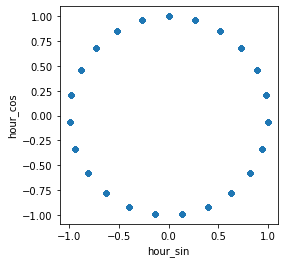

In [36]:
# check with a scatter plot of the two new features if the encoding is correct
df_availability_and_weather.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

### Understanding Data

In [37]:
# Look at correlations for all the continuous features.
df_availability_and_weather[['temperature', 'cloudiness', 'windSpeed', 'rain', 'snow', 'hour_sin', 'hour_cos', 'availableBikes']].corr()

,temperature,cloudiness,windSpeed,rain,snow,hour_sin,hour_cos,availableBikes
temperature,1.000000,0.121272,0.288680,-0.015413,NaN,-0.335960,-0.300240,-0.099632
cloudiness,0.121272,1.000000,0.189760,0.081764,NaN,0.056242,-0.037829,-0.002879
windSpeed,0.288680,0.189760,1.000000,0.097880,NaN,-0.144454,-0.105984,-0.085962
rain,-0.015413,0.081764,0.097880,1.000000,NaN,-0.032149,-0.041557,-0.001022
snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hour_sin,-0.335960,0.056242,-0.144454,-0.032149,NaN,1.000000,-0.004714,0.022930
hour_cos,-0.300240,-0.037829,-0.105984,-0.041557,NaN,-0.004714,1.000000,0.032687
availableBikes,-0.099632,-0.002879,-0.085962,-0.001022,NaN,0.022930,0.032687,1.000000


In [38]:
df_availability_and_weather['snow'].value_counts()

0.0    488289
Name: snow, dtype: int64

NaN values are expected for snow since at the moment the values are all 0s, it doesn't vary
- There isn't a linear relationship between any of the continuous features and the target feature
- However, we are trying to fit a model with many features at once and linear regression may still be a good fit in this higher dimensional space

## Training the model with continuous features
*Below we do this for all features - continuous and categorical - and compare*
#### Multiple linear regression

*Preparing the data*

In [39]:
cont_features = ['temperature', 'cloudiness', 'windSpeed', 'rain', 'snow', 'hour_sin', 'hour_cos']

**We are building a model per station so each station data needs to be filtered from the original CSV**

In [61]:
# get station rows from original csv
def filter_station_data(df, station_id):
    station_df = df.loc[(df['stationId'] == station_id)]
    return station_df

In [62]:
# Our data should already be ordered by default, but just to make sure
def order_df_by_lastUpdate(station_df):
    station_df_time_ordered = station_df.sort_values(['lastUpdate'])
    # need to reset index after sorting
    station_df_time_ordered_reset = station_df_time_ordered.reset_index(drop=True)
    return station_df_time_ordered_reset

In [63]:
# Looking into the TimeSeriesSplit() function of scikit-learn, it does not appear that you can specify
        # the n_split part by day of the week or hour. This is something we need to do and create multiple subsets for
        # each station and train a model for each subset if we decide on that
        
# TODO if we want to train a model per day of the week for each station
def get_sation_subsets_by_day(station_df_ordered):
    pass

In [64]:
def get_station_features_and_target(station_dataframe_ordered, features):
    X = station_dataframe_ordered[features]
    y = station_dataframe_ordered.availableBikes
    print("\nDescriptive features in X:\n", X)
    print("\nTarget feature in y:\n", y)
    return X, y

In [65]:
# (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
def split_time_series_data(X, y, number_splits, number_test_size, number_gap):
    # we can set different test sizes and splits to see the difference in the outcome
    # we can also add a gap between train and test data
    tscv = TimeSeriesSplit(n_splits=number_splits, test_size=number_test_size, gap=number_gap)
    for train_index, test_index in tscv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test

In [71]:
# fit model to training data
def apply_linear_model_to_training_data(X_training_data, y_training_data):
    model_for_station = LinearRegression().fit(X_training_data, y_training_data)
    return model_for_station

In [72]:
def train_linear_model_per_station(df, station_id, features, number_splits, number_test_size, number_gap):
    # initialise a dict that will store the station models
    station_model = {}
    
    # get rows with stationId == station_id separated by descriptive features and target feature
    df_station_data = filter_station_data(df, station_id)
    
    # get station data ordered by lastUpdate to make sure data is in ordered by time sequentially 
    df_station_time_ordered = order_df_by_lastUpdate(df_station_data)
    
    # separate descriptive features from target feature
    X, y = get_station_features_and_target(df_station_time_ordered, features)
    
    # split data into test and training data using TimeSeriesSplit     
    X_train, X_test, y_train, y_test = split_time_series_data(X, y, number_splits, number_test_size, number_gap)
    
    # Train a model on training data
    model_for_station = apply_linear_model_to_training_data(X_train, y_train)
    
    # store the model in a dictionary with stationId as key
    station_model[station_id] = {"Features": features, "Coeficients": model_for_station.coef_.tolist(), "Intercept": model_for_station.intercept_}
    
    # return station model in a dictionary
    return station_model, model_for_station, X_train, X_test, y_train, y_test

In [73]:
# function to predict target feature on training data
def predictions_for_training_data(model_for_station, X_training_data):
    train_predictions = model_for_station.predict(X_training_data)
    return train_predictions

In [74]:
# calculate all metrics
def printMetrics(testActualVal, predictions):
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

*Check model predictions for a couple of stations with continuous features only (below we do the same but with all features and compare)*

In [75]:
# station with Id = 2
station_model_2, model_for_station_2, X_train_2, X_test_2, y_train_2, y_test_2 = train_linear_model_per_station(df_availability_and_weather, 2, cont_features, number_splits=5, number_test_size=2, number_gap=0)


Descriptive features in X:
       temperature  cloudiness  windSpeed  rain  snow  hour_sin  hour_cos
0            9.34        75.0       2.57   0.0   0.0 -0.997669 -0.068242
1            9.20        75.0       1.03   0.0   0.0 -0.997669 -0.068242
2            9.48        75.0       1.03   0.0   0.0 -0.997669 -0.068242
3            9.22        75.0       1.03   0.0   0.0 -0.979084  0.203456
4            8.85        75.0       0.51   0.0   0.0 -0.979084  0.203456
...           ...         ...        ...   ...   ...       ...       ...
4372         8.17        90.0       7.72   0.0   0.0 -0.398401 -0.917211
4373         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211
4374         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211
4375         8.17        90.0       7.20   0.0   0.0 -0.631088 -0.775711
4376         8.17        90.0       7.20   0.0   0.0 -0.631088 -0.775711

[4377 rows x 7 columns]

Target feature in y:
 0       10
1       10
2       10
3       11
4  

In [50]:
# station with Id = 82
station_model_82, model_for_station_82, X_train_82, X_test_82, y_train_82, y_test_82 = train_linear_model_per_station(df_availability_and_weather, 82, cont_features, number_splits=5, number_test_size=2, number_gap=0)


Descriptive features in X:
       temperature  cloudiness  windSpeed  rain  snow  hour_sin  hour_cos
0            9.78        75.0       2.57   0.0   0.0 -0.997669 -0.068242
1            9.39        75.0       2.57   0.0   0.0 -0.997669 -0.068242
2            9.21        75.0       1.03   0.0   0.0 -0.997669 -0.068242
3            9.47        75.0       1.03   0.0   0.0 -0.997669 -0.068242
4            9.08        75.0       1.03   0.0   0.0 -0.979084  0.203456
...           ...         ...        ...   ...   ...       ...       ...
4434         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211
4435         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211
4436         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211
4437         8.17        90.0       7.20   0.0   0.0 -0.631088 -0.775711
4438         8.17        90.0       7.20   0.0   0.0 -0.631088 -0.775711

[4439 rows x 7 columns]

Target feature in y:
 0       5
1       5
2       5
3       4
4      

In [77]:
# model learned for station 2
station_model_2

{2: {'Features': ['temperature',
   'cloudiness',
   'windSpeed',
   'rain',
   'snow',
   'hour_sin',
   'hour_cos'],
  'Coeficients': [0.004116107678291528,
   -0.00011311464975966674,
   -0.1754422141978078,
   -0.33759774279195726,
   1.3877787807814457e-17,
   -0.015889152546133975,
   -0.4266473626575546],
  'Intercept': 7.510742486518044}}

In [78]:
# station 2 predictions on training data
train_predictions_2 = predictions_for_training_data(model_for_station_2, X_train_2)
train_predictions_2

array([7.1347844 , 7.40438915, 7.40554166, ..., 6.57743291, 6.66866286,
       6.66866286])

In [79]:
# station 2 metrics
print("Actual vs predicted on training:\n", pd.concat([y_train_2, pd.DataFrame(train_predictions_2, columns=['Predicted'], index=y_train_2.index)], axis=1))
printMetrics(y_train_2, train_predictions_2)

Actual vs predicted on training:
       availableBikes  Predicted
0                 10   7.134784
1                 10   7.404389
2                 10   7.405542
3                 11   7.288257
4                 11   7.377964
...              ...        ...
4370               7   6.487628
4371               7   6.577227
4372               7   6.577433
4373               7   6.668663
4374               7   6.668663

[4375 rows x 2 columns]

MAE:  3.675405440833226
MSE:  19.070874666434023
RMSE:  4.367021257840866
R2:  0.014843492825813764


In [80]:
# Predict availability on test set for each station
def predictions_on_test_data(model, X_test_data, y_test_data):
    test_predictions_station = model.predict(X_test_data)
    print("Actual vs predicted on test:\n", pd.concat([y_test_data, pd.DataFrame(test_predictions_station, columns=['Predicted'], index=y_test_data.index)], axis=1))
    printMetrics(y_test_data, test_predictions_station)

In [81]:
# Predicted availability on test set for station 2
predictions_on_test_data(model_for_station_2, X_test_2, y_test_2)

Actual vs predicted on test:
       availableBikes  Predicted
4375               7   6.611989
4376               7   6.611989

MAE:  0.38801054547274916
MSE:  0.15055218339806034
RMSE:  0.38801054547274916
R2:  0.0


In [82]:
# station 82 predictions
train_predictions_82 = predictions_for_training_data(model_for_station_82, X_train_82)
train_predictions_82

array([7.57472273, 7.73359437, 7.21216808, ..., 9.96402698, 9.96402698,
       9.96402698])

In [83]:
# station 82 metrics
print("Actual vs predicted on training:\n", pd.concat([y_train_82, pd.DataFrame(train_predictions_82, columns=['Predicted'], index=y_train_82.index)], axis=1))
printMetrics(y_train_82, train_predictions_82)

Actual vs predicted on training:
       availableBikes  Predicted
0                  5   7.574723
1                  5   7.733594
2                  5   7.212168
3                  4   7.106254
4                  4   7.543696
...              ...        ...
4432               7  10.185220
4433               7  10.185220
4434               7   9.964027
4435               7   9.964027
4436               7   9.964027

[4437 rows x 2 columns]

MAE:  3.169612618861027
MSE:  15.547038206518772
RMSE:  3.9429732698204756
R2:  0.19942929454831615


In [84]:
# Predicted availability on test set for station 82
predictions_on_test_data(model_for_station_82, X_test_82, y_test_82)

Actual vs predicted on test:
       availableBikes  Predicted
4437               6   9.918839
4438               6   9.918839

MAE:  3.918839104969889
MSE:  15.3572999306412
RMSE:  3.918839104969889
R2:  0.0


## Training the model with continuous and categorical features

**Adding `mainWeather` and `weekday`**

In [85]:
weekday_dummies = pd.get_dummies(df_availability_and_weather['weekday'], prefix='weekday', drop_first=True)
print("Weekday Dummies:", weekday_dummies)

Weekday Dummies:         weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
0                    0                 1               0                 0   
1                    0                 1               0                 0   
2                    0                 1               0                 0   
3                    0                 1               0                 0   
4                    0                 1               0                 0   
...                ...               ...             ...               ...   
488284               0                 0               0                 1   
488285               0                 0               0                 1   
488286               0                 0               0                 1   
488287               0                 0               0                 1   
488288               0                 0               0                 1   

        weekday_Tuesday  weekday_Wednesday  
0

In [86]:
mainWeather_dummies = pd.get_dummies(df_availability_and_weather['mainWeather'], prefix='mainWeather', drop_first=True)
print("Main Weather Dummies:", mainWeather_dummies)

Main Weather Dummies:         mainWeather_Clouds  mainWeather_Drizzle  mainWeather_Fog  \
0                        1                    0                0   
1                        1                    0                0   
2                        1                    0                0   
3                        1                    0                0   
4                        1                    0                0   
...                    ...                  ...              ...   
488284                   1                    0                0   
488285                   1                    0                0   
488286                   1                    0                0   
488287                   1                    0                0   
488288                   1                    0                0   

        mainWeather_Mist  mainWeather_Rain  
0                      0                 0  
1                      0                 0  
2                      0  

In [87]:
categ_features = weekday_dummies.columns.values.tolist() + mainWeather_dummies.columns.values.tolist()

In [88]:
categ_features

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'mainWeather_Clouds',
 'mainWeather_Drizzle',
 'mainWeather_Fog',
 'mainWeather_Mist',
 'mainWeather_Rain']

In [89]:
cont_features

['temperature',
 'cloudiness',
 'windSpeed',
 'rain',
 'snow',
 'hour_sin',
 'hour_cos']

In [90]:
all_features = cont_features + categ_features
print("\nCont features: ", cont_features)
print("Categ features: ", categ_features)
print("Features: ", all_features)


Cont features:  ['temperature', 'cloudiness', 'windSpeed', 'rain', 'snow', 'hour_sin', 'hour_cos']
Categ features:  ['weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'mainWeather_Clouds', 'mainWeather_Drizzle', 'mainWeather_Fog', 'mainWeather_Mist', 'mainWeather_Rain']
Features:  ['temperature', 'cloudiness', 'windSpeed', 'rain', 'snow', 'hour_sin', 'hour_cos', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'mainWeather_Clouds', 'mainWeather_Drizzle', 'mainWeather_Fog', 'mainWeather_Mist', 'mainWeather_Rain']


In [91]:
df_availability_and_weather

,stationId,totalStands,availableBikes,freeStands,lastUpdate,mainWeather,temperature,cloudiness,windSpeed,rain,snow,weekday,fullHour,hour_sin,hour_cos
0,2,20,10,10,2021-02-27 17:35:14,Clouds,9.34,75.0,2.57,0.0,0.0,Saturday,17,-0.997669,-0.068242
1,2,20,10,10,2021-02-27 17:45:23,Clouds,9.20,75.0,1.03,0.0,0.0,Saturday,17,-0.997669,-0.068242
2,2,20,10,10,2021-02-27 17:55:32,Clouds,9.48,75.0,1.03,0.0,0.0,Saturday,17,-0.997669,-0.068242
3,2,20,11,9,2021-02-27 18:00:42,Clouds,9.22,75.0,1.03,0.0,0.0,Saturday,18,-0.979084,0.203456
4,2,20,11,9,2021-02-27 18:10:51,Clouds,8.85,75.0,0.51,0.0,0.0,Saturday,18,-0.979084,0.203456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488284,117,40,3,37,2021-04-01 13:39:58,Clouds,8.13,90.0,7.72,0.0,0.0,Thursday,13,-0.398401,-0.917211
488285,117,40,4,36,2021-04-01 13:47:32,Clouds,8.18,90.0,7.20,0.0,0.0,Thursday,13,-0.398401,-0.917211
488286,117,40,4,36,2021-04-01 13:57:38,Clouds,8.18,90.0,7.20,0.0,0.0,Thursday,13,-0.398401,-0.917211
488287,117,40,4,36,2021-04-01 14:07:44,Clouds,8.18,90.0,7.20,0.0,0.0,Thursday,14,-0.631088,-0.775711


In [92]:
df_availability_and_weather_all_features = pd.get_dummies(df_availability_and_weather, columns=['mainWeather', 'weekday'], drop_first=True)
df_availability_and_weather_all_features

,stationId,totalStands,availableBikes,freeStands,lastUpdate,temperature,cloudiness,windSpeed,rain,snow,...,mainWeather_Drizzle,mainWeather_Fog,mainWeather_Mist,mainWeather_Rain,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2,20,10,10,2021-02-27 17:35:14,9.34,75.0,2.57,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,2,20,10,10,2021-02-27 17:45:23,9.20,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,2,20,10,10,2021-02-27 17:55:32,9.48,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,2,20,11,9,2021-02-27 18:00:42,9.22,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,2,20,11,9,2021-02-27 18:10:51,8.85,75.0,0.51,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488284,117,40,3,37,2021-04-01 13:39:58,8.13,90.0,7.72,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
488285,117,40,4,36,2021-04-01 13:47:32,8.18,90.0,7.20,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
488286,117,40,4,36,2021-04-01 13:57:38,8.18,90.0,7.20,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
488287,117,40,4,36,2021-04-01 14:07:44,8.18,90.0,7.20,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [93]:
# save this dataframe as .csv file
df_availability_and_weather_all_features.to_csv("stations_dataframe_all_features.csv")

*Train the model for the same stations but with all features and check results*

In [101]:
# station with Id = 2
station_model_all_2, model_for_station_all_2, X_train_all_2, X_test_all_2, y_train_all_2, y_test_all_2 = train_linear_model_per_station(df_availability_and_weather_all_features, 2, all_features, number_splits=5, number_test_size=2, number_gap=0)


Descriptive features in X:
       temperature  cloudiness  windSpeed  rain  snow  hour_sin  hour_cos  \
0            9.34        75.0       2.57   0.0   0.0 -0.997669 -0.068242   
1            9.20        75.0       1.03   0.0   0.0 -0.997669 -0.068242   
2            9.48        75.0       1.03   0.0   0.0 -0.997669 -0.068242   
3            9.22        75.0       1.03   0.0   0.0 -0.979084  0.203456   
4            8.85        75.0       0.51   0.0   0.0 -0.979084  0.203456   
...           ...         ...        ...   ...   ...       ...       ...   
4372         8.17        90.0       7.72   0.0   0.0 -0.398401 -0.917211   
4373         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211   
4374         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211   
4375         8.17        90.0       7.20   0.0   0.0 -0.631088 -0.775711   
4376         8.17        90.0       7.20   0.0   0.0 -0.631088 -0.775711   

      weekday_Monday  weekday_Saturday  weekday_Sunday  we

In [102]:
# station with Id = 82
station_model_all_82, model_for_station_all_82, X_train_all_82, X_test_all_82, y_train_all_82, y_test_all_82 = train_linear_model_per_station(df_availability_and_weather_all_features, 82, all_features, number_splits=5, number_test_size=2, number_gap=0)


Descriptive features in X:
       temperature  cloudiness  windSpeed  rain  snow  hour_sin  hour_cos  \
0            9.78        75.0       2.57   0.0   0.0 -0.997669 -0.068242   
1            9.39        75.0       2.57   0.0   0.0 -0.997669 -0.068242   
2            9.21        75.0       1.03   0.0   0.0 -0.997669 -0.068242   
3            9.47        75.0       1.03   0.0   0.0 -0.997669 -0.068242   
4            9.08        75.0       1.03   0.0   0.0 -0.979084  0.203456   
...           ...         ...        ...   ...   ...       ...       ...   
4434         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211   
4435         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211   
4436         8.17        90.0       7.20   0.0   0.0 -0.398401 -0.917211   
4437         8.17        90.0       7.20   0.0   0.0 -0.631088 -0.775711   
4438         8.17        90.0       7.20   0.0   0.0 -0.631088 -0.775711   

      weekday_Monday  weekday_Saturday  weekday_Sunday  we

In [103]:
station_model_all_2

{2: {'Features': ['temperature',
   'cloudiness',
   'windSpeed',
   'rain',
   'snow',
   'hour_sin',
   'hour_cos',
   'weekday_Monday',
   'weekday_Saturday',
   'weekday_Sunday',
   'weekday_Thursday',
   'weekday_Tuesday',
   'weekday_Wednesday',
   'mainWeather_Clouds',
   'mainWeather_Drizzle',
   'mainWeather_Fog',
   'mainWeather_Mist',
   'mainWeather_Rain'],
  'Coeficients': [-0.11156028352180689,
   -0.004316848018155628,
   -0.09684106161543071,
   -0.07589078136507929,
   -1.7763568394002505e-15,
   -0.2741370301653539,
   -0.4479728013542243,
   2.23155455043894,
   0.5387347602910437,
   1.851670289124137,
   -0.8282753443727162,
   1.7013028061923756,
   0.36898231413670246,
   2.6870416376051462,
   5.352823391027198,
   -1.0877216021644522,
   -0.4717850049618635,
   2.3367245815104365],
  'Intercept': 4.855482875152543}}

In [104]:
station_model_all_82

{82: {'Features': ['temperature',
   'cloudiness',
   'windSpeed',
   'rain',
   'snow',
   'hour_sin',
   'hour_cos',
   'weekday_Monday',
   'weekday_Saturday',
   'weekday_Sunday',
   'weekday_Thursday',
   'weekday_Tuesday',
   'weekday_Wednesday',
   'mainWeather_Clouds',
   'mainWeather_Drizzle',
   'mainWeather_Fog',
   'mainWeather_Mist',
   'mainWeather_Rain'],
  'Coeficients': [-0.7597669423094046,
   0.02227087549094381,
   0.5192888079686827,
   0.4447420696542873,
   -3.552713678800501e-15,
   0.17842224009915025,
   0.5950406930168697,
   3.7500284610262087,
   -0.2086723670816209,
   0.20733664246601713,
   0.6835511454373593,
   4.680337809566064,
   3.4830227400295373,
   1.3091830067165466,
   3.4489272183489774,
   -2.220446049250313e-16,
   -2.002805547621781,
   1.2569772254610627],
  'Intercept': 8.939768290780712}}

In [105]:
# station 2 predictions with all features on training data
train_predictions_all_2 = predictions_for_training_data(model_for_station_all_2, X_train_all_2)
train_predictions_all_2

array([6.77070979, 6.93546347, 6.90422659, ..., 5.18677454, 5.23713189,
       5.23713189])

In [106]:
# station 2 metrics
print("Actual vs predicted on training:\n", pd.concat([y_train_all_2, pd.DataFrame(train_predictions_all_2, columns=['Predicted'], index=y_train_all_2.index)], axis=1))
printMetrics(y_train_all_2, train_predictions_all_2)

Actual vs predicted on training:
       availableBikes  Predicted
0                 10   6.770710
1                 10   6.935463
2                 10   6.904227
3                 11   6.806424
4                 11   6.898059
...              ...        ...
4370               7   5.146310
4371               7   5.192353
4372               7   5.186775
4373               7   5.237132
4374               7   5.237132

[4375 rows x 2 columns]

MAE:  3.478123772382083
MSE:  17.72756545353203
RMSE:  4.2104115539376945
R2:  0.08423568565306006


In [107]:
# Predicted availability for station 2 with all features on test data
predictions_on_test_data(model_for_station_all_2, X_test_all_2, y_test_all_2)

Actual vs predicted on test:
       availableBikes  Predicted
4375               7   5.237532
4376               7   5.237532

MAE:  1.7624681784836351
MSE:  3.1062940801674226
RMSE:  1.7624681784836351
R2:  0.0


In [108]:
# station 82 predictions on training data with all features
train_predictions_all_82 = predictions_for_training_data(model_for_station_all_82, X_train_all_82)
train_predictions_all_82

array([5.39603282, 5.69234193, 5.02939522, ..., 9.85160307, 9.85160307,
       9.85160307])

In [109]:
# station 82 metrics
print("Actual vs predicted on training:\n", pd.concat([y_train_all_82, pd.DataFrame(train_predictions_all_82, columns=['Predicted'], index=y_train_all_82.index)], axis=1))
printMetrics(y_train_all_82, train_predictions_all_82)

Actual vs predicted on training:
       availableBikes  Predicted
0                  5   5.396033
1                  5   5.692342
2                  5   5.029395
3                  4   4.831856
4                  4   5.293152
...              ...        ...
4432               7  10.159622
4433               7  10.159622
4434               7   9.851603
4435               7   9.851603
4436               7   9.851603

[4437 rows x 2 columns]

MAE:  2.829492836627031
MSE:  12.848603978263332
RMSE:  3.584494940471158
R2:  0.33838099486790707


In [110]:
# Predicted availability for station 82 with all features on test data
predictions_on_test_data(model_for_station_all_82, X_test_all_82, y_test_all_82)

Actual vs predicted on test:
       availableBikes  Predicted
4437               6   9.894285
4438               6   9.894285

MAE:  3.89428482709825
MSE:  15.165454314567649
RMSE:  3.89428482709825
R2:  0.0


*Both models seem to improve with fitting with all features but is it good enough?*